# Negation analysis for improved sentiment prediction

#### Motivation

Stop words are words that are essential for a sentence to make sense, such as: “I”, “the”, “and”, etc. The issue with stop words is that they are very *frequent* and *uninformative*. So, it is suitable for most NLP applications to remove them from the text. 

Common NLP libraries (e.g., NLTK, spaCy, scikit-learn, etc.) provide pre-compiled lists of stop words. These lists include a few negation words such as: 
- `no`, `nor`, `not`
- `do`, `don't`, `didn't`, `wouldn't`.

However, removing negation words from the text may be undesirable for some tasks, such as sentiment analysis. For example, if we use these lists to remove stopwords from our text, then sentences such as: `"I don't like this movie"`, will become `"like this movie"`. We see that the cleaned sentence conveys the opposite sentiment from the original sentence! I would like to investigate to what extend this may have a negative effect on the performance of sentiment (text) classifiers.

#### My goals

In this notebook, I would like to:
* clean the text so that the negation words aren't removed. 
* work around incompatibilities between NLTK's stopwords list, stemmers and tokenizers.
* investigate whether keeping negation words in the text helps to improve the performance of text classifiers.

I will use a "hate-speech" dataset collected from Twitter (available on Kaggle).

#### Inspiration 

* [What’s Great and What’s Not: Learning to Classify the Scope of Negation
for Improved Sentiment Analysis](http://static.googleusercontent.com/media/research.google.com/fr//pubs/archive/36744.pdf), 2010.
* [On the negativity of negation](https://web.stanford.edu/~cgpotts/papers/potts-salt20-negation.pdf), 2011.

In [1]:
# Load dependencies

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as  plt

import matplotlib.cm as cm
COLOR_1 = cm.get_cmap("Set2")(2) # set blue 
COLOR_2 = cm.get_cmap("Set2")(1) # set orange

import re, os, random, string
from math import ceil
from src import base
from collections import defaultdict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Loading the data

In [2]:
# Path to the data

PATH_DATA = os.path.join('./data/train_E6oV3lV.csv')

In [3]:
# Load data
df = pd.read_csv(PATH_DATA, usecols=[1,2])

# Re-order columns
df = df[['tweet','label']].copy()

# Drop duplicates and empty lines
df = df.drop_duplicates('tweet')
df.dropna(inplace = True)

# Reset index
df.reset_index(inplace=True,drop=True)

print('Data shape: ',df.shape)

Data shape:  (29530, 2)


In [4]:
# Print a few samples

with pd.option_context('display.max_colwidth', 500):
    display(df.sample(3))

,tweet,label
12954,*presses play #pharrell #summer,0
16775,#dancing #t-shi wordans,0
7630,@user it's also as if he has no idea what his own words mean-- he must be homeschooled. @user,0


## Preliminary EDA
### Class imbalance

Let’s check the distribution of samples in the target variable.

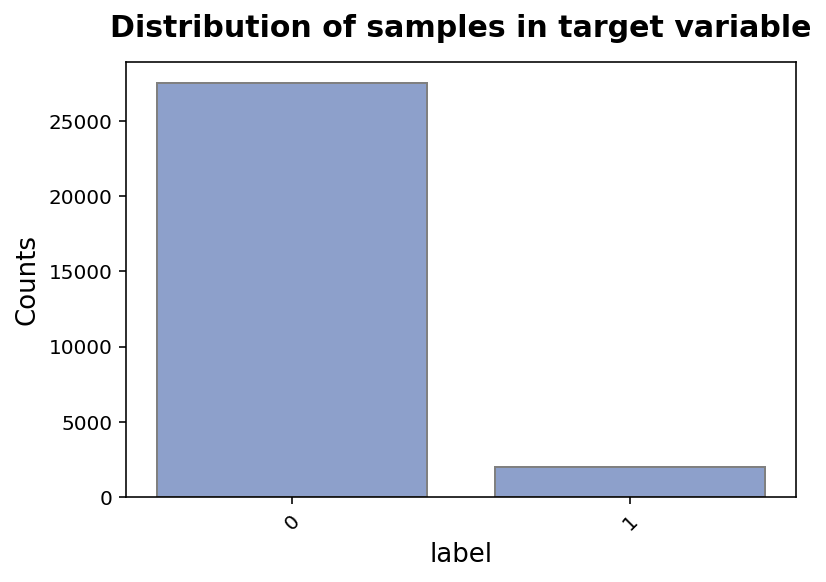

In [5]:
# Count neutral/non-neutral tweets

# Create an instance of the PrelimEDA class
prelimEDA = base.PrelimEDA()

# Plot distribution of samples in target
prelimEDA.target_sample_distribution(df,target='label')

For "neutral" tweets, the target value is 0; for hate-speech tweets, it is 1. We have many more neutral tweets (93,2%) than hate-speech tweets (6,8%); the dataset is *imbalanced*. I will have to account for the class imbalance in the ML part where I will training a text classifier.

Let's have a look at the class ratio.

In [6]:
class_ratio = int(np.ceil(len(np.where(df['label'] == 0)[0])/len(np.where(df['label'] == 1)[0])))
print('The minority to majority class ratio is: 1:{}.'.format(class_ratio))

The minority to majority class ratio is: 1:14.


In [7]:
# Print a few samples from class 0

with pd.option_context('display.max_colwidth', 500):
    display(df[df['label'] == 0].sample(3))

,tweet,label
20744,@user the only way you can find this data for public hospitals is if you go to the hospital and count yourself.,0
21183,my shi has finally arrived! #worshipgeneration #philippians413 #makingworshipalifestyle,0
944,"@user may lights triumph over darkness. may this ramadan bring peace, harmony and joy. #ramadan! #ramadankareem",0


In [8]:
# Print a few samples from class 1

with pd.option_context('display.max_colwidth', 500):
    display(df[df['label'] == 1].sample(3))

,tweet,label
14008,@user @user america is great without you assholes. #xenophobia and #lockerroomtalk aren't what #maga #notmypresident,1
12722,you'd think #blacklivesmatter would b protesting #plannedparenthood 24/7 but it doesn't fit their #ideology.,1
2057,"show me your tits, idiot!",1


## Text preprocessing

Text data can be “messy”, especially from social media platforms. Moreover, not all terms in a text help to make good predictions. For these reasons, we usually start by preprocessing our text, i.e., “cleaning” it to keep only “informative” terms and remove other, less useful terms. Text preprocessing also aims to reduce the overall number of unique words in a dataset, using techniques such as case conversion and stemming, as we will see later. Overall, text preprocessing can improve training by reducing the memory required to handle the data, speeding up computations, and improving model performance.

As I wrote above, I also want to make sure that i don't remove negation words from tweets during cleaning. Here is how I plan to mainten negation words in the text:
- Expand contractions: e.g. don't like -> do not like, using Python libraries
- Detect negation words in text: add an underscore at the end of them and capitalize them. This way, they won't be removed by the stop words lists. Example: `not` -> `NOT_`, `never` -> `NEVER_`
- Remove stopwords using the nltk stopwords list for english (capitalized negation words with trailing underscores won't be removed).
- Concatenate negation words with the negated word in a single token: e.g. `[NOT_, like]` -> `[NOT_like]`.

Then sentences like: `"I don't like this movie"`, becomes `['NOT_like', 'this', 'movie']`. 

### Tokenization

Tokenization is the process of splitting text into smaller segments (usually words) called tokens and is utilized both during preprocessing and feature extraction.

The `TweetTokenizer` and `casual_tokenize` tokenizers fron NLTK are good options for text from social media. Below are a few key options they offer:
- `reduce_length`: reduces the number of repeated characters within a token e.g. "everrrrr" -> "everrr"
- `strip_handles`:  strip usernames
- preserve punctuations and emoticons.

Below, I will use the `TweetTokenizer`.

In [11]:
from nltk.tokenize import TweetTokenizer

# Create an instance of the Tokenizer
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                           reduce_len=True)

Let’s use the TreebankWordTokenizer with the text sample from above.

In [12]:
# Show an example:

sample = "wahhhh!!!!! white ppl arent allowed to do this!!! fuck you rich. we don't care ð never believe"

print("Before tokenization: \n{}\n".format(sample))
print("After tokenization: \n{}\n".format(tokenizer.tokenize(sample)))

Before tokenization: 
wahhhh!!!!! white ppl arent allowed to do this!!! fuck you rich. we don't care ð never believe

After tokenization: 
['wahhh', '!', '!', '!', 'white', 'ppl', 'arent', 'allowed', 'to', 'do', 'this', '!', '!', '!', 'fuck', 'you', 'rich', '.', 'we', "don't", 'care', 'ð', 'never', 'believe']



### Expand contractions

As discussed above, I will expand contractions (e.g. `don't`->`do not`, `didn't`->`did not`, etc.). Later, this will allow me to discard the auxiliary very (usually *uniformative*) and concatenate the negation word with the negated word. 

I will use the Python library `contractions`.

In [13]:
# Import library for contractions

#!pip install contractions
import contractions

In [14]:
# Test contractions library on a sample

print("Before expanding contractions: \n{}\n".format(sample))
print("After expanding contractions: \n{}\n".format(contractions.fix(sample)))

Before expanding contractions: 
wahhhh!!!!! white ppl arent allowed to do this!!! fuck you rich. we don't care ð never believe

After expanding contractions: 
wahhhh!!!!! white ppl are not allowed to do this!!! fuck you rich. we do not care ð never believe



### Stopwords

Below, I will use the stop words list provided by the NLTK library for English.

In [15]:
# Load english stopwords from nltk
import nltk
nltk.download("stopwords", quiet=True)

from nltk.corpus import stopwords
stopwords_english = stopwords.words("english")

In [16]:
# Print stopwords

print("{} stopwords in NLTK's list.\n".format(len(stopwords_english)))
print(stopwords_english)

179 stopwords in NLTK's list.

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',

As I wrote above, NLTK's stop words list contains a few negation words. Let's see a few examples.

In [17]:
# Check if 'not' is in stopwords_english

"not" in stopwords_english

True

In [18]:
# Check if "don't" is in stopwords_english

"don't" in stopwords_english

True

### Negation words

I have identified the following negation words that I want to keep in the text after cleaning: `not`, `no`, `never`. Below, I will add a trailing underscore and capitalize them to make them "incompatible" with NLTK's stopwords list.

In [19]:
# List of words expressing negation

negation_l = ['not','no','never']
print(negation_l)

# Add underscore at the end and capitalize
negation_l_cap = [w.swapcase()+'_' for w in negation_l]
print(negation_l_cap)

['not', 'no', 'never']
['NOT_', 'NO_', 'NEVER_']


### Stemming

Stemming is a commonly used technique for reducing vocabulary size. It is the process of converting a word to its “root” or “stem”, mainly by stripping suffixes from the end of a word. Note that stemming can produce non-words, i.e., words that you won’t find in a dictionary, so lemmatization may be preferable if you need your preprocessed text to be “readable”.

The Porter stemmer is widely used for English text and is available in the NLTK library.

In [20]:
# Load stemmer
from nltk.stem.porter import PorterStemmer

# Create an instance of the PorterStemmer object
stemmer = PorterStemmer()

### Preprocessing

Now let’s put everything together and create the `clean_tweet` function, which processes a tweet.

In [21]:
# Create clean_tweet function

def clean_tweet(tweet,model_negation,to_stem):
    
    '''
    The clean_tweet, preprocesses and tokenizes tweets:
    
    - Removes @user
    - Removes the hash # sign from the word
    - Removes numbers
    - Removes non-ascii chars
    - Removes excessive whitespace
    - Removes multiple periods (e.g. .., ...)
    - Removes the "'s" from the end of words (not removed otherwise)
    - if model_negation: 
        - expands contractiong and makes negation words incompatible with
        stopwords list
    - Removes punctuation, stopwords and single-character words
    - if mode_negation:
        - concatenates negation word with negated word
    - if to_stem: applies stemming
    
    Tokenizer used: TweetTokenizer
    
    INPUTS: 
    - tweet: a string
    - model_negation: boolean (T/F)
    - to_stem:  boolean (T/F)
    
    OUTPUT: 
    - list of tokens
    
    Example: "@user is in town and like we don't even see each other? ð¤"
    With negation modeling and stemming:  ['town', 'like', 'not_even', 'see']
    
    '''
    
    clean_tweet = tweet

    # Remove @user
    clean_tweet = re.sub(r'@user','',tweet)

    # Remove the hash # sign from the word
    clean_tweet = re.sub(r'#',' ',clean_tweet)
    
    # Remove URLs
    clean_tweet = re.sub(r'https?:\/\/[^\s]+', '', clean_tweet)

    # Remove numbers
    clean_tweet = re.sub(r'\d+','',clean_tweet)
    
    # Remove non-ascii chars
    clean_tweet = ''.join([c for c in str(clean_tweet) if ord(c) < 128])

    # Remove multiple whitespace
    clean_tweet = re.sub(r'\s+',' ',clean_tweet)

    # Remove multiple periods
    clean_tweet = re.sub(r'\.+',' ',clean_tweet)
    
    # Remove genitif
    clean_tweet = re.sub(r"'s",' ',clean_tweet)

    # Strip whitespace
    clean_tweet = clean_tweet.strip()
    
    if model_negation:
        #Expand contractions
        clean_tweet = contractions.fix(clean_tweet)
    
    # Tokenize tweet
    tweet_l = tokenizer.tokenize(clean_tweet)

    if model_negation:
        # Add underscore at the end of negation words and capitalize them e.g. not -> NOT_
        tweet_l = [w if w not in negation_l else w.swapcase() + '_' for w in tweet_l]

    # Remove punctuation, stopwords and single-char words
    tweet_l = [w for w in tweet_l if (w not in string.punctuation) and
               (w not in stopwords_english) and (len(w)>1)]

    if len(tweet_l) == 0:
        return tweet_l

    else:
        if model_negation:
            
            # Concatenated negation word with negated word in list: 
            # e.g. ['NOT_','believe'] -> ['NOT_believe']
            for neg_w in negation_l_cap:

                idx_l = np.where(np.array(tweet_l)==neg_w)[0]

                # Mupliple neg_w in tweets: update index to account for shifting after merging
                update_idx = 0

                for i in range(0,len(idx_l)):

                    idx = idx_l[i] - update_idx
                    
                    if (idx != len(tweet_l) - 1): # Don't concatenate if @ the end of list
                        tweet_l[idx:idx+2] = [''.join([tweet_l[idx],tweet_l[idx+1]])]
                        update_idx += 1

        # Remove punctuation & stopwords (no need to exclude 'not' and 'no')
        if to_stem:
            tweet_l = [stemmer.stem(w) for w in tweet_l]
       
        return tweet_l
    

Let’s test this function with a few examples.

In [22]:
# Example #1
tweet = sample
print('Raw tweet: {}\n'.format(tweet))

# Clean tweet
print('Capturing negation and applying stemming:\n',clean_tweet(tweet,model_negation=True,to_stem=True))
print()
print('Without capturing negation and stemming:\n',clean_tweet(tweet,model_negation=False,to_stem=False))

Raw tweet: wahhhh!!!!! white ppl arent allowed to do this!!! fuck you rich. we don't care ð never believe

Capturing negation and applying stemming:
 ['wahhh', 'white', 'ppl', 'not_allow', 'fuck', 'rich', 'not_car', 'never_believ']

Without capturing negation and stemming:
 ['wahhh', 'white', 'ppl', 'arent', 'allowed', 'fuck', 'rich', 'care', 'never', 'believe']


In [23]:
# Example #2: Sample a tweet randomly
tweet =  df.iloc[random.randint(0,len(df)),0]
print('Raw tweet: {}\n'.format(tweet))

# Clean tweet
print('Capturing negation and applying stemming:\n',clean_tweet(tweet,model_negation=True,to_stem=True))
print()
print('Without capturing negation and stemming:\n',clean_tweet(tweet,model_negation=False,to_stem=False))

Raw tweet: people move to another state and expect to get different results.  

Capturing negation and applying stemming:
 ['peopl', 'move', 'anoth', 'state', 'expect', 'get', 'differ', 'result']

Without capturing negation and stemming:
 ['people', 'move', 'another', 'state', 'expect', 'get', 'different', 'results']


Let’s now go ahead and apply the `clean_tweet` function to all of the data. I will add the processed text to a new column `clean_tweet` in the dataframe df.

In [24]:
%%time

# Create clean_tweet column
# Use the clean_tweet function
df['clean_tweet'] = df['tweet'].apply(lambda x: clean_tweet(x,model_negation=True,
                                                            to_stem=True))
print('Shape: ',df.shape)

# Some more cleaning
df['length'] = df['clean_tweet'].apply(len)
df = df[df['length'] != 0]
df = df.drop('length',axis=1).copy()

# Re-order columns
df = df[['tweet','clean_tweet','label']].copy()

df.reset_index(inplace=True,drop=True)
print('Data shape: ',df.shape)
# Wall time: 7.76 s

Shape:  (29530, 3)
Data shape:  (29494, 3)
CPU times: user 8.48 s, sys: 48.6 ms, total: 8.53 s
Wall time: 8.58 s


In [25]:
# Print a few samples

with pd.option_context('display.max_colwidth', 500):
    display(df.sample(3))

,tweet,clean_tweet,label
21943,succulents. our favorite addiction. âð»ï¸ðµð #humpday #succulents #sunshine #summerlove #diyâ¦,"[succul, favorit, addict, humpday, succul, sunshin, summerlov, diy]",0
3785,"""@user woah yeah!! finally it's beginning to show!! #proud ððªð»[ @user yeahhhh!!","[woah, yeah, final, begin, show, proud, yeahhh]",0
21319,wrong people to even talk about bro ugh i feel so bad ððð #sosad,"[wrong, peopl, even, talk, bro, ugh, feel, bad, sosad]",0


## More EDA

### Tweet length

The following plot shows the distribution of characters in tweets.

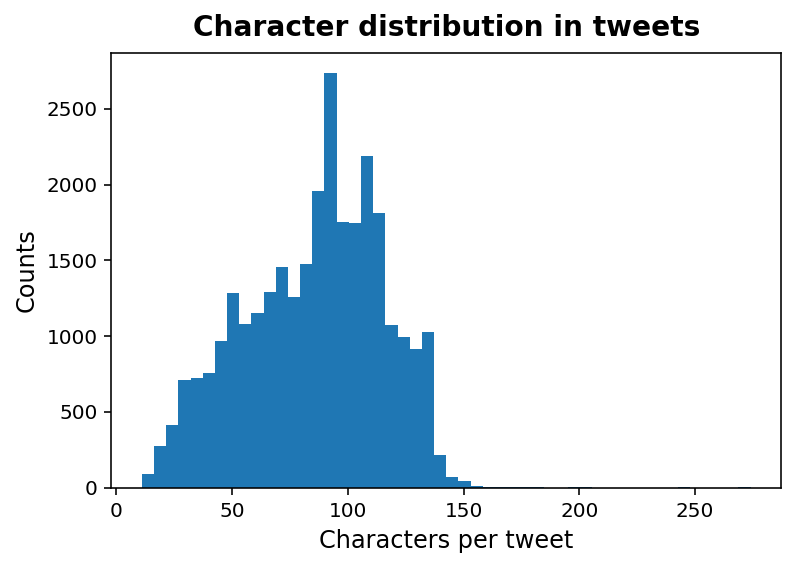

In [26]:
label_specs   = {"fontsize": 12}
title_specs   = {"fontsize": 14, "fontweight": "bold", "y": 1.01}

plt.figure(figsize=(6,4))
plt.hist(df['tweet'].apply(lambda x:len(x)), bins = 50)
plt.xlabel('Characters per tweet', **label_specs);
plt.title('Character distribution in tweets',**title_specs);
plt.ylabel('Counts',**label_specs);

In [27]:
# Summary statistics of the number of chars
df['tweet'].apply(lambda x:len(x)).describe()

count    29494.000000
mean        85.333322
std         29.832655
min         11.000000
25%         63.000000
50%         89.000000
75%        108.000000
max        274.000000
Name: tweet, dtype: float64

* Max number of characters per tweet: 274 (<280)
* 75% of tweets have up to 108 chars.

### Token distribution in tweets

The following plot shows the distribution of tokens in tweets.

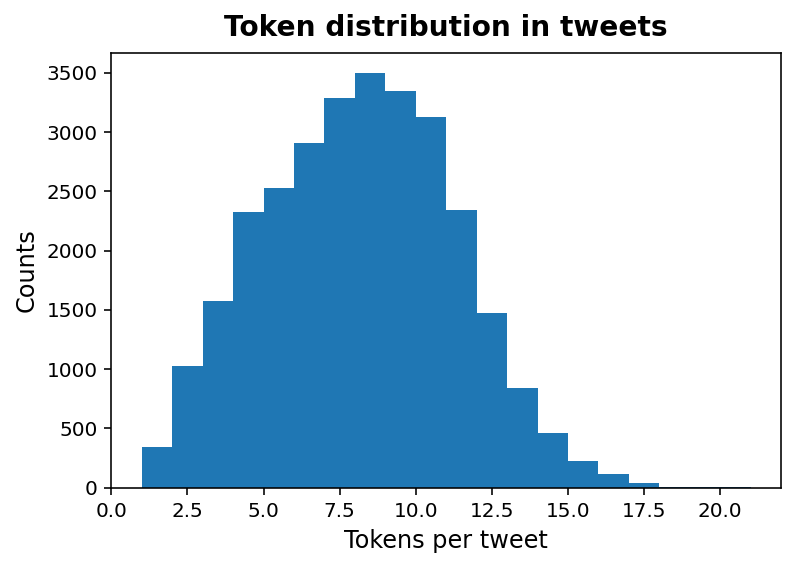

In [28]:
plt.figure(figsize=(6,4))
plt.hist(df['clean_tweet'].apply(lambda x:len(x)), bins = 20)
plt.xlabel('Tokens per tweet', **label_specs);
plt.title('Token distribution in tweets',**title_specs);
plt.ylabel('Counts',**label_specs);

In [29]:
max_seq = df['clean_tweet'].apply(lambda x:len(x)).max()
print('Maximum number of tokens in tweets: {}'.format(max_seq))

Maximum number of tokens in tweets: 21


In [30]:
# Sanity check

df['clean_tweet'].apply(len).describe()

count    29494.000000
mean         7.666339
std          3.120298
min          1.000000
25%          5.000000
50%          8.000000
75%         10.000000
max         21.000000
Name: clean_tweet, dtype: float64

### What are the most common words in tweets?

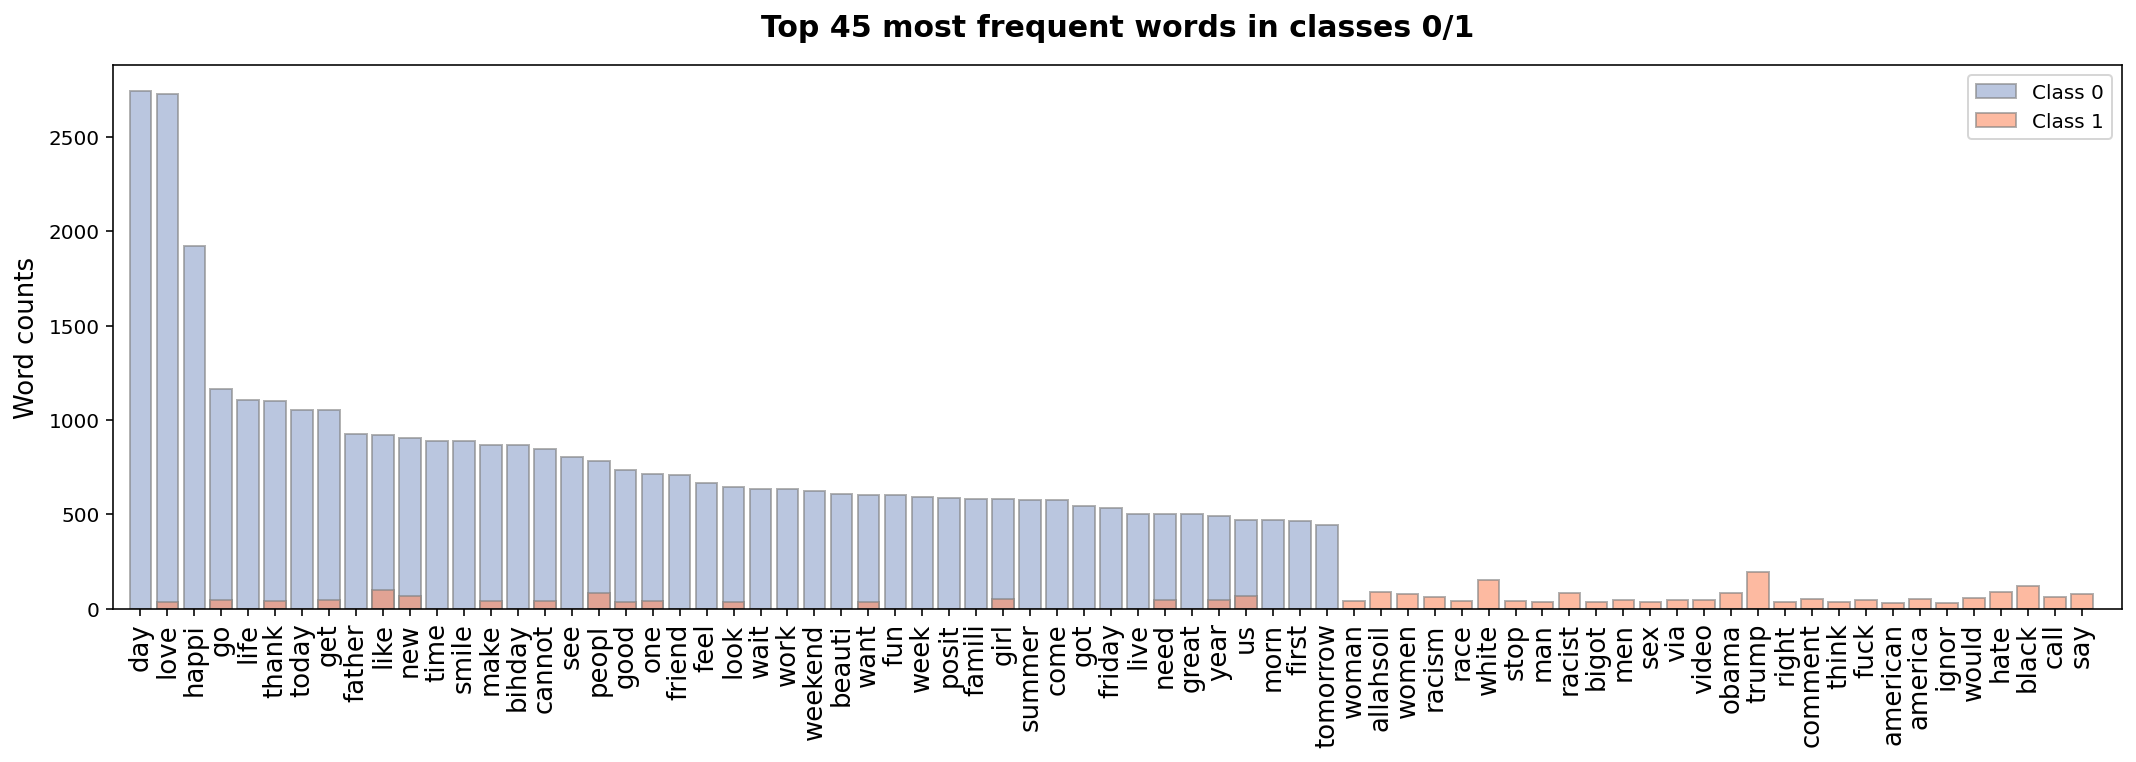

In [31]:
prelimEDA.plot_most_common_words(df, N = 45)

 As we can see, some words appear mostly or exclusively in one of the two classes. Examples of such words are:
 - class 0: day, love, lif, smile, etc.
 - class 1: white, allalsoil, trump, etc.
 
There words are distinctive of each of the two classes. They are strong indicators of each of the two classes.

Note that I could also have a look at the words which are mostly related with the two classes using the $chi^2$ statistic.

### What are the most common negation words in tweets?

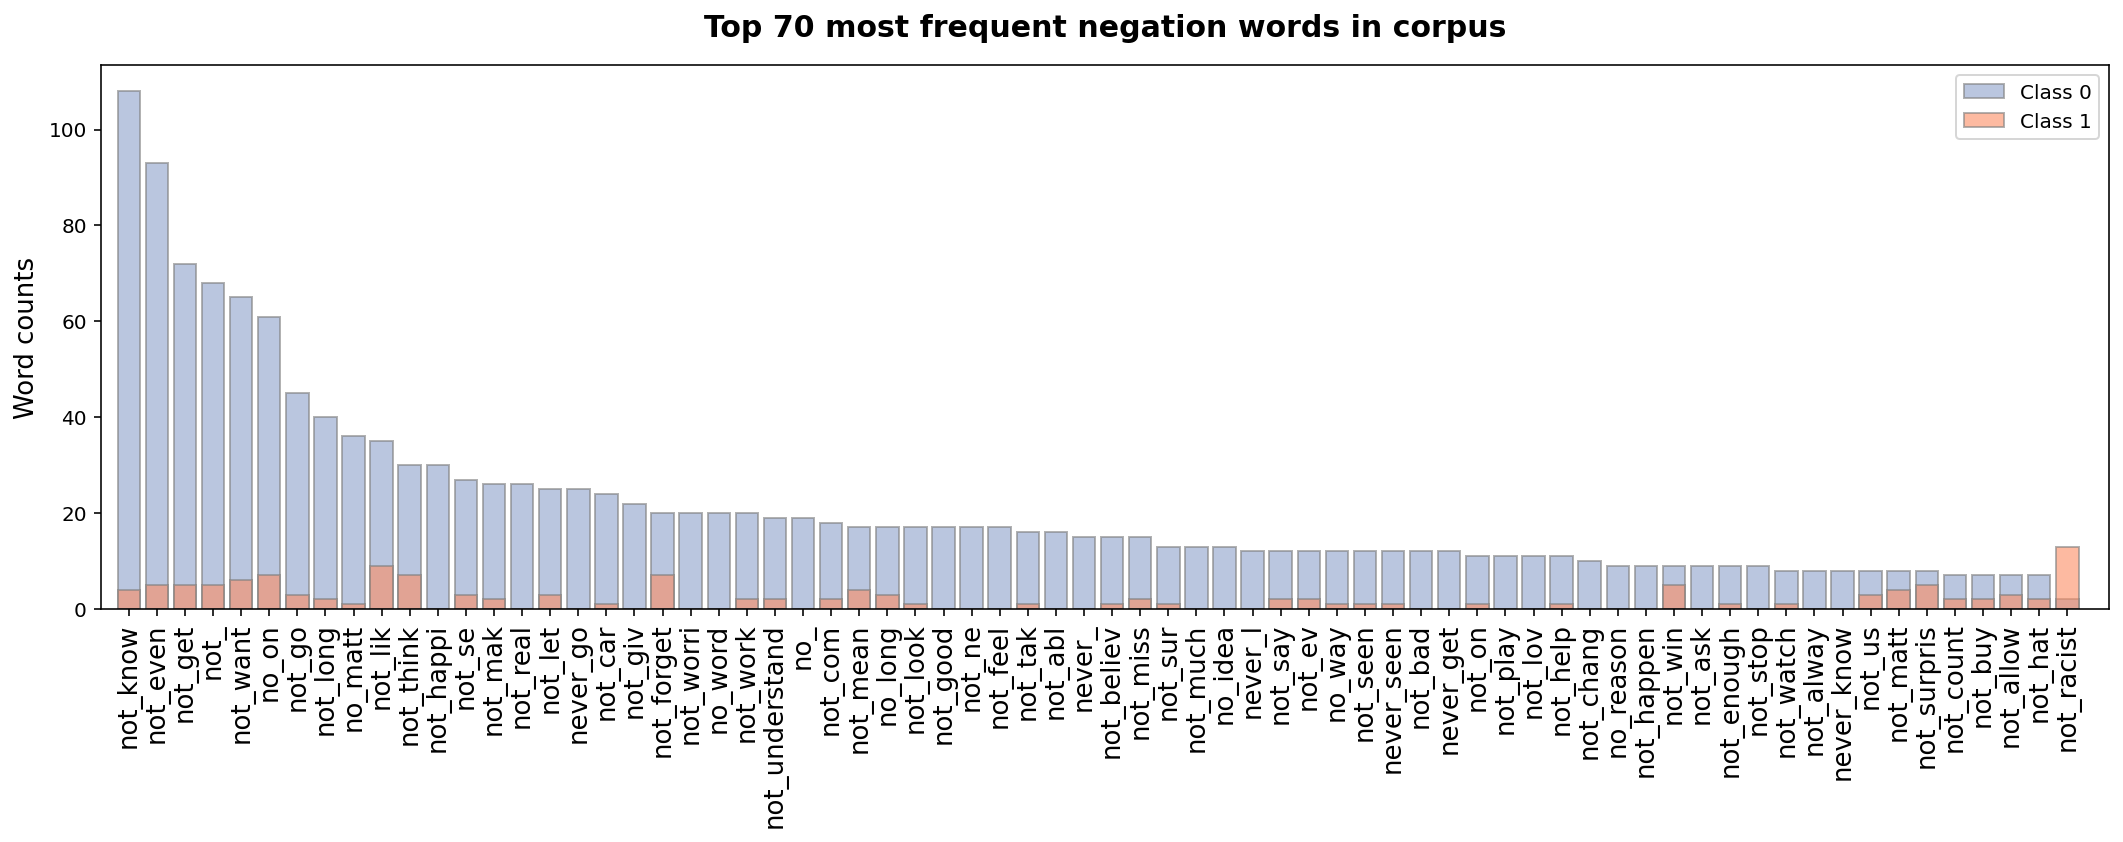

In [34]:
prelimEDA.most_common_negation_words(df,N = 70)

**Observations**

- negation words are rare (~2% of total word counts)
- appear mostly in class 0 tweets (so, we could say that they are distinctive of class 0).

## Machine Learning : Building a text classifier

### Train/test splitting  

First, I will split the data into training/test data. The test data will be used for computing the generalization error. The training data will be used for model fitting and hyperparameter tuning using cross-validation.

In [35]:
from sklearn.model_selection import train_test_split

# Create X/y arrays
X = df['tweet'] # Unpreprocessed texts
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=0.2)
X_train = X_train.values
y_train = y_train.values
X_test  = X_test.values
y_test  = y_test.values

print('Train set: ',X_train.shape,y_train.shape)
print('Test set: ',X_test.shape,y_test.shape)

Train set:  (23595,) (23595,)
Test set:  (5899,) (5899,)


### Vocabulary

The number of unique words in a dataset is usually called the vocabulary. I will now create the vocabulary from the training data. 

In [36]:
# Print a few samples from X_train
# This is unpreprocessed text

X_train[20:25]

array(['that streetcar was a bust.  ',
       'happy feet. happy hea!  #walk #sunny #magical #beautiful   #love #nature #sky #amazingâ\x80¦ ',
       ' @user one day to go until the the wedding awards with the magic mirror. @user  #imperialwarmuseum   ',
       'ugh we just moved &amp; da kids really got me in da house by myself already..  ',
       'cultural day was lit! #fashion#love#fun#instagood#beautiful #selfie @ university of beninâ\x80¦ '],
      dtype=object)

In [37]:
def create_vocab(X, top_w, neg_bool, stem_bool):
    
    '''
    Creates vocabulary from training data
    - freq: dict with word frequency
    - top_w=-1 : consider all words in vocabulary
    - vocab: word2Index wocabulary
    '''
    
    # Special tokens
    special_l = ['__PAD__','__</e>__','__UNK__']

    # Create freq dictionary
    # w : freq
    freq = defaultdict(int)

    for tweet in X:
        for w in clean_tweet(tweet,neg_bool,stem_bool):
            freq[w] += 1
        
    # Sort dictionary in descending order
    freq_sorted = {k:v for k,v in sorted(freq.items(), 
                                         key=lambda item:item[1], reverse=True)}

    # Concatenate special tokens with vocabulary words (sorted)
    sorted_l  = special_l + list(freq_sorted.keys())
    
    print('Number of unique words in corpus: {}'.format(len(sorted_l)))

    # Map vocabulary words to unique index 
    #(from most frequent -> to least frequent)
    
    vocab = {}
    
    if top_w == -1:
        top_words = len(sorted_l)
    else:
        top_words = top_w
        print('Vocabulary size: {}\n'.format(top_words))
    
    for w in sorted_l[0:top_w]:
            vocab[w] = len(vocab)

    return (freq_sorted,vocab)

In [41]:
%%time
freq, vocab = create_vocab(X_train, top_w=-1, neg_bool=True, stem_bool=True)

# Wall time: 5.9 s

Number of unique words in corpus: 28876
CPU times: user 6.33 s, sys: 6.92 ms, total: 6.34 s
Wall time: 6.34 s


`vocab` is a word2Index wocabulary mapping vocabulary words to a unique index. Let's print a few (k,v) pairs from vocab.

In [42]:
# Print a few pairs from the vocabulary
{k:vocab[k] for k in list(vocab)[0:10]}

{'__PAD__': 0,
 '__</e>__': 1,
 '__UNK__': 2,
 'day': 3,
 'love': 4,
 'happi': 5,
 'go': 6,
 'thank': 7,
 'life': 8,
 'get': 9}

`freq` is a sorted dict with word frequencies. Let's print a few (k,v) pairs from `freq`.

In [45]:
# Print a few pairs from the freq dictionary
{k:freq[k] for k in list(freq)[0:10]}

{'day': 2226,
 'love': 2225,
 'happi': 1561,
 'go': 950,
 'thank': 894,
 'life': 887,
 'get': 877,
 'today': 845,
 'like': 815,
 'new': 768}

### Prepare text for neural networks

In [46]:
def tweet_to_tensor(tweet,vocab_dict,neg_bool,stem_bool,seq_len=20):
    
    '''
    The tweet_to_tensor:
    - preprocesses tweets with the clean_tweet function
    - maps tokens to vocabulary indexes
    - pads sequences according to seq_len
    
    INPUTS: 
    - tweet: a string
    - vocab_dict: the vocabulary
    - seq_len: max length of sequences
    - neg_bool: boolean (model negation or not)
    - stem_bool: boolean (stem or not)
    
    OUTPUT: 
    - list of vocabulary indexes
    
    Example: 
    --------
    Tweet:         "@user is in town and like we don't even see each other? ð¤"
    Clean tweet:   ['town', 'like', 'not_even', 'see']
    Tweet tensor:  [5587, 135, 1833, 790, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 
    '''
    
    # Get index for <UNK> token
    unknown_token='__UNK__'
    unk_ID = vocab_dict.get(unknown_token,0)  # 2
    
    # Clean and tokenize tweet
    tweet_l = clean_tweet(tweet,neg_bool,stem_bool)

    # Map tokens to vocab index
    tweet_tensor = []
    for w in tweet_l:
        tweet_tensor.append(vocab_dict.get(w,unk_ID))  # Replace OOV by 2

    # Pad sequences 
    len_0 = len(tweet_tensor)

    if len_0 <= seq_len:
        pad_l = seq_len - len_0 # post-PADDING
        tweet_tensor_pad = tweet_tensor + [0]*pad_l
    else:                       # Concatenate to max seq_length
        tweet_tensor_pad = tweet_tensor[0:seq_len]

    return tweet_tensor_pad


In [49]:
# Check an example from training data

rdn_idx = random.randint(0,len(X_train))
tweet = X_train[rdn_idx]

print('Sample tweet:\n',tweet,'\n')
print('Preprocessed tweet:\n',clean_tweet(tweet,model_negation=True,to_stem=True),'\n')
print('Tensorized tweet:\n',tweet_to_tensor(tweet,vocab,True,True),'\n')

Sample tweet:
 it's your republicans, like paul ryan, kasich, sen. kirk, etc., who are calling @user the racist.   @user 

Preprocessed tweet:
 ['republican', 'like', 'paul', 'ryan', 'kasich', 'sen', 'kirk', 'etc', 'call', 'racist'] 

Tensorized tweet:
 [980, 11, 2162, 4207, 8130, 14297, 14298, 1557, 137, 299, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 



In [61]:
# More sanity checks

tweet =  X_test[random.randint(0,len(X_test))]
#tweet = "wahhhh!!!!! white ppl arent allowed to do this!!! ððð. fuck you rich. we don't care ð never believe"
#tweet = " i ain't jewish, i just don't dig on swine, that's all	"
#tweet = "@user i did and im"
#tweet = "met this girl 5 yrs ago online b-ng gay friend. y does she look like this when she didn't b4?  @user"
#tweet = "are you making excuses as to why you can't be now? here's help: #happinessrocks"

print('Sample tweet:\n',tweet,'\n')
print('Cleaned tweet:\n',clean_tweet(tweet,model_negation=True,to_stem=True),'\n')
print('Cleaned tweet:\n',tweet_to_tensor(tweet,vocab,True,True),'\n')

Sample tweet:
  @user "beautiful girls all over the world"  ð¤ðµð¶ð¸   #brunomars  

Cleaned tweet:
 ['beauti', 'girl', 'world', 'brunomar'] 

Cleaned tweet:
 [28, 30, 48, 7919, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 



### Batch generators

I will use generators for training the neural networds.

In [62]:
# ================================== #
# Batch generator with shuffling
# (for training data)
# ================================== #

def train_gen(X, y, neg_bool, stem_bool,batch_size):
    
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    while 1: #run forever, so you can generate elements indefinitely
        for i in range(0, len(y), batch_size):
            # Batch indexes
            batch_idx = shuffled_idx[i:i+batch_size]

            batch_X = []
            for doc in X[batch_idx]:
                batch_X.append(tweet_to_tensor(doc,vocab,neg_bool,stem_bool))

            yield np.array(batch_X), y[batch_idx]

# ================================== #
# Batch generator without shuffling
# (for val/test data)
# ================================== #

def val_test_gen(X, y, neg_bool, stem_bool, batch_size):
    # Do not shuffle X,y
    idx = np.arange(len(y)) # 1,2,...,n

    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    while 1: #run forever, so you can generate elements indefinitely
        for i in range(0, len(y), batch_size):
            # Batch indexes
            batch_idx = idx[i:i+batch_size]

            batch_X = []
            for doc in X[batch_idx]:
                batch_X.append(tweet_to_tensor(doc,vocab,neg_bool,stem_bool))

            yield np.array(batch_X), y[batch_idx]

### Neural network model

In [63]:
# Load dependencies

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_loss',patience=6)]

# Metrics
from sklearn.metrics import f1_score,accuracy_score, precision_score, recall_score

In [64]:
# Set parameters

maxlen = 20           # Sequence (document) length
embedding_dims = 400  # Embedding size
voc_size = len(vocab) # Size of the vocabulary

batch_size = 256
epochs = 200

In [65]:
len(vocab)

28875

In [66]:
# Create nn model

def create_model():
    model = Sequential()
    model.add(Embedding(voc_size, embedding_dims, input_length=maxlen))  # input: (voc_size, embedding_size, seq_length) 
                                                                        # output: (None, seq_length, emb_size)
    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    #model.summary()
    
    # Compile model
    model.compile(loss='binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

    return model

In [67]:
# Print model summary

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 400)           11550000  
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 8001      
Total params: 11,558,001
Trainable params: 11,558,001
Non-trainable params: 0
_________________________________________________________________


2022-01-31 17:26:28.217793: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [68]:
# Function to preprocess data

def encode_data(X, neg_bool, stem_bool):
    X_encoded = []
    
    for doc in X:
        X_encoded.append(tweet_to_tensor(doc,vocab,neg_bool,stem_bool))
    
    return np.array(X_encoded)

In [69]:
# Setting parameters for grid-search

from sklearn.model_selection import ParameterGrid

# Define a grid of values
grid = ParameterGrid({
    'class_weights': [{0:1,1:1}, {0:1,1:5}, {0:1,1:10}, {0:1,1:15}, {0:1,1:20}],
    'neg': [True,False]
})

# Print the number of combinations
print('Number of combinations:', len(grid))

Number of combinations: 10


In [70]:
for params_dict in grid:
    # Set parameters
    print(params_dict,params_dict['class_weights'],params_dict['neg'])

{'class_weights': {0: 1, 1: 1}, 'neg': True} {0: 1, 1: 1} True
{'class_weights': {0: 1, 1: 1}, 'neg': False} {0: 1, 1: 1} False
{'class_weights': {0: 1, 1: 5}, 'neg': True} {0: 1, 1: 5} True
{'class_weights': {0: 1, 1: 5}, 'neg': False} {0: 1, 1: 5} False
{'class_weights': {0: 1, 1: 10}, 'neg': True} {0: 1, 1: 10} True
{'class_weights': {0: 1, 1: 10}, 'neg': False} {0: 1, 1: 10} False
{'class_weights': {0: 1, 1: 15}, 'neg': True} {0: 1, 1: 15} True
{'class_weights': {0: 1, 1: 15}, 'neg': False} {0: 1, 1: 15} False
{'class_weights': {0: 1, 1: 20}, 'neg': True} {0: 1, 1: 20} True
{'class_weights': {0: 1, 1: 20}, 'neg': False} {0: 1, 1: 20} False


In [72]:
#results = pd.DataFrame(gs_results)

In [73]:
#results.to_csv('GS_results_HS_neg_full_emb_400_cv_10.csv',index=False)

In [71]:
results = pd.read_csv('data/GS_results_HS_neg_full_emb_400_cv_10.csv')
results.head(5)

,neg,run_idx,train_acc,train_f1,train_prec,train_recall,val_acc,val_f1,val_prec,val_recall,weight
0,True,0,0.999523,0.996491,0.999218,0.993779,0.956559,0.589178,0.830508,0.456522,1
1,False,0,0.999682,0.997664,0.999220,0.996112,0.953380,0.571984,0.765625,0.456522,1
2,True,0,0.999735,0.998060,0.996127,1.000000,0.953380,0.598540,0.725664,0.509317,5
3,False,0,0.999682,0.997673,0.995356,1.000000,0.947023,0.562937,0.644000,0.500000,5
4,True,0,0.999735,0.998060,0.996127,1.000000,0.948930,0.576450,0.663968,0.509317,10


In [74]:
# Extract f1 cols
f1_cols = [col for col in results if "_f1" in col]
f1_cols = f1_cols + ['weight','neg']

results_f1 = results[f1_cols]
results_f1.head()

,train_f1,val_f1,weight,neg
0,0.996491,0.589178,1,True
1,0.997664,0.571984,1,False
2,0.998060,0.598540,5,True
3,0.997673,0.562937,5,False
4,0.998060,0.576450,10,True


In [75]:
## Negation

# Extract results with negation
results_neg_f1 = results_f1[results_f1['neg'] == True].drop('neg',axis=1)

# Compute mean values
results_neg_f1_m = results_neg_f1.groupby('weight').mean()
results_neg_f1_m.columns = ['mean_train_f1','mean_val_f1']

# Compute std
results_neg_f1_std = results_neg_f1.groupby('weight').std()
results_neg_f1_std.columns = ['std_train_f1','std_val_f1']

# Concatenate
results_neg_f1_t = pd.concat([results_neg_f1_m,results_neg_f1_std],axis=1)
results_neg_f1_t.reset_index(inplace=True)
results_neg_f1_t

,weight,mean_train_f1,mean_val_f1,std_train_f1,std_val_f1
0,1,0.997390,0.592591,0.000804,0.018398
1,5,0.998602,0.584367,0.000491,0.022620
2,10,0.998602,0.570999,0.000417,0.023152
3,15,0.998641,0.568773,0.000457,0.021025
4,20,0.998641,0.563345,0.000457,0.022431


In [76]:
## w/o Negation

# Extract results without negation
results_no_neg_f1 = results_f1[results_f1['neg'] == False].drop('neg',axis=1)

# Compute mean values
results_no_neg_f1_m = results_no_neg_f1.groupby('weight').mean()
results_no_neg_f1_m.columns = ['mean_train_f1','mean_val_f1']

# Compute std
results_no_neg_f1_std = results_no_neg_f1.groupby('weight').std()
results_no_neg_f1_std.columns = ['std_train_f1','std_val_f1']

# Concatenate
results_no_neg_f1_t = pd.concat([results_no_neg_f1_m,results_no_neg_f1_std],axis=1)
results_no_neg_f1_t.reset_index(inplace=True)
results_no_neg_f1_t

,weight,mean_train_f1,mean_val_f1,std_train_f1,std_val_f1
0,1,0.998365,0.580223,0.000604,0.020808
1,5,0.998137,0.566790,0.000627,0.023984
2,10,0.998138,0.560746,0.000572,0.018048
3,15,0.998215,0.553486,0.000523,0.019957
4,20,0.998215,0.548002,0.000523,0.019886


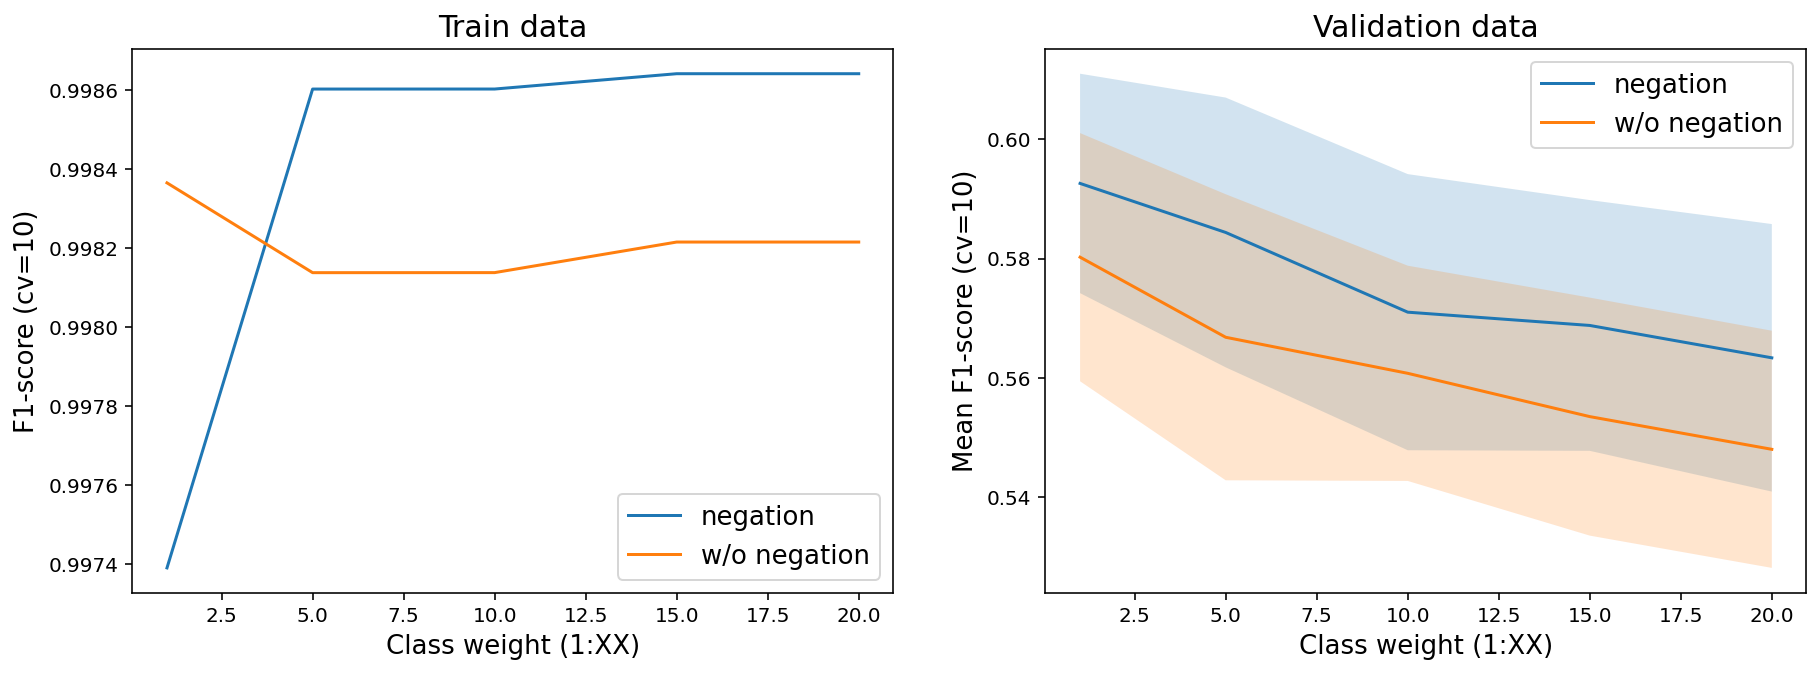

In [77]:
import matplotlib.pyplot as plt

fig,axes = plt.subplots(1,2,figsize=(15,5))

axes[0].plot(results_neg_f1_t['weight'],results_neg_f1_t['mean_train_f1'],label='negation')
axes[0].plot(results_no_neg_f1_t['weight'],results_no_neg_f1_t['mean_train_f1'],label='w/o negation')

axes[0].legend(fontsize=13)
axes[0].set_title('Train data',fontsize=15)
axes[0].set_ylabel('F1-score (cv=10)',fontsize=13)
axes[0].set_xlabel('Class weight (1:XX)',fontsize=13)

axes[1].plot(results_neg_f1_t['weight'],results_neg_f1_t['mean_val_f1'],label='negation')
axes[1].plot(results_no_neg_f1_t['weight'],results_no_neg_f1_t['mean_val_f1'],label='w/o negation')

# Quantify variance with ±std curves
axes[1].fill_between(results_neg_f1_t['weight'], results_neg_f1_t['mean_val_f1']-results_neg_f1_t['std_val_f1'], 
                     results_neg_f1_t['mean_val_f1']+results_neg_f1_t['std_val_f1'], alpha=0.2)
axes[1].fill_between(results_no_neg_f1_t['weight'], results_no_neg_f1_t['mean_val_f1']-results_no_neg_f1_t['std_val_f1'], 
                     results_no_neg_f1_t['mean_val_f1']+results_no_neg_f1_t['std_val_f1'], alpha=0.2)

axes[1].legend(fontsize=13)
axes[1].set_title('Validation data',fontsize=15)
axes[1].set_ylabel('Mean F1-score (cv=10)',fontsize=13)
axes[1].set_xlabel('Class weight (1:XX)',fontsize=13);

In [78]:
results.head()

,neg,run_idx,train_acc,train_f1,train_prec,train_recall,val_acc,val_f1,val_prec,val_recall,weight
0,True,0,0.999523,0.996491,0.999218,0.993779,0.956559,0.589178,0.830508,0.456522,1
1,False,0,0.999682,0.997664,0.999220,0.996112,0.953380,0.571984,0.765625,0.456522,1
2,True,0,0.999735,0.998060,0.996127,1.000000,0.953380,0.598540,0.725664,0.509317,5
3,False,0,0.999682,0.997673,0.995356,1.000000,0.947023,0.562937,0.644000,0.500000,5
4,True,0,0.999735,0.998060,0.996127,1.000000,0.948930,0.576450,0.663968,0.509317,10


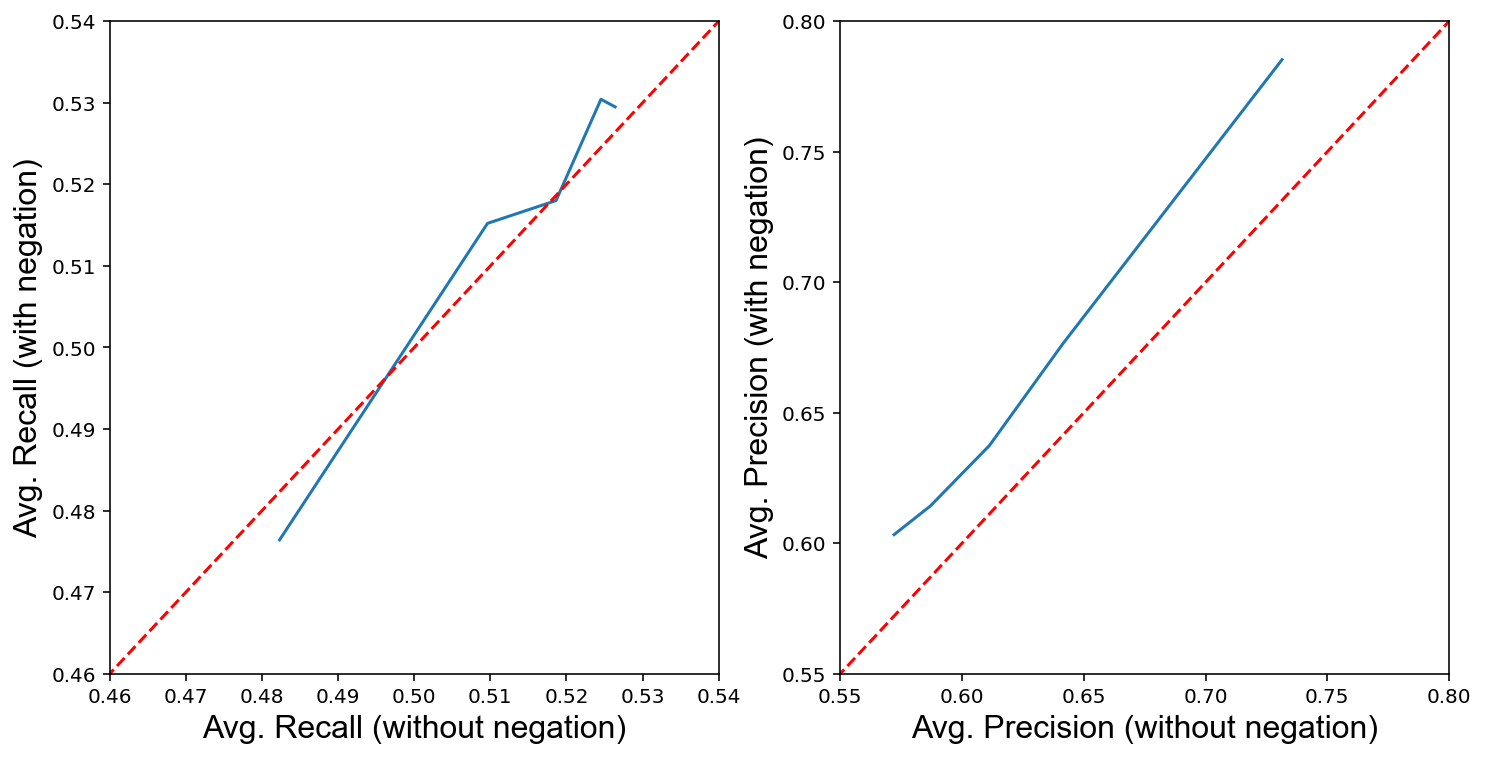

In [79]:
# Plot Precision-recall curve
# ===========================

font = {'fontname':'Arial', 'size':'16'}
font_title = {'fontname':'Arial', 'size':'19'}

fig,axes = plt.subplots(1,2,figsize=(12,6))
axes[0].set_xlim([0.46,0.54])
axes[0].set_ylim([0.46,0.54])

axes[0].plot(results[results['neg'] == False].groupby('weight').mean()['val_recall'],
         results[results['neg'] == True].groupby('weight').mean()['val_recall'])
axes[0].plot([0.4,1],[0.4,1],'r--')

axes[0].set_xlabel('Avg. Recall (without negation)',**font)
axes[0].set_ylabel('Avg. Recall (with negation)',**font)

###

axes[1].set_xlim([0.55,0.8])
axes[1].set_ylim([0.55,0.8])

axes[1].plot(results[results['neg'] == False].groupby('weight').mean()['val_prec'],
         results[results['neg'] == True].groupby('weight').mean()['val_prec'])
axes[1].plot([0.4,1],[0.4,1],'r--')

axes[1].set_xlabel('Avg. Precision (without negation)',**font)
axes[1].set_ylabel('Avg. Precision (with negation)',**font)

plt.show()

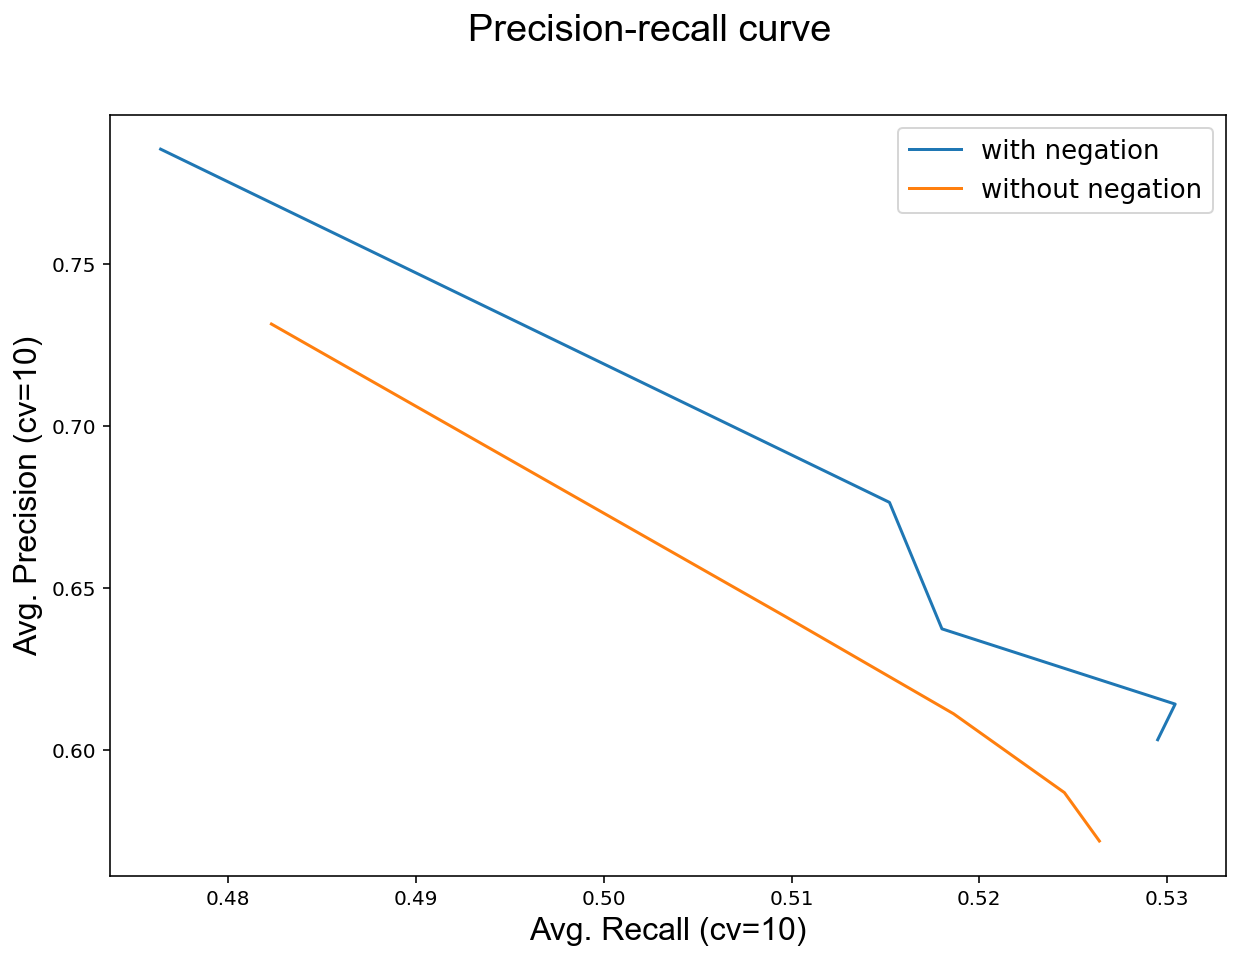

In [80]:
# Plot Precision-recall curve
# ===========================

font = {'fontname':'Arial', 'size':'16'}
font_title = {'fontname':'Arial', 'size':'19'}

plt.figure(figsize=(10,7))

plt.suptitle('Precision-recall curve',**font_title)

plt.plot(results[results['neg'] == True].groupby('weight').mean()['val_recall'], 
         results[results['neg'] == True].groupby('weight').mean()['val_prec'],label='with negation')
plt.plot(results[results['neg'] == False].groupby('weight').mean()['val_recall'], 
         results[results['neg'] == False].groupby('weight').mean()['val_prec'],label='without negation')

plt.ylabel('Avg. Precision (cv=10)',**font)
plt.xlabel('Avg. Recall (cv=10)',**font)
plt.legend(fontsize=13)
plt.show()

In [81]:
results[results['neg'] == True].groupby('weight').mean()

,neg,run_idx,train_acc,train_f1,train_prec,train_recall,val_acc,val_f1,val_prec,val_recall
weight,,,,,,,,,,
1,1.0,4.5,0.999645,0.997390,0.999220,0.995568,0.955287,0.592591,0.785286,0.476398
5,1.0,4.5,0.999809,0.998602,0.997286,0.999922,0.949905,0.584367,0.676409,0.515217
10,1.0,4.5,0.999809,0.998602,0.997209,1.000000,0.946832,0.570999,0.637422,0.518012
15,1.0,4.5,0.999815,0.998641,0.997287,1.000000,0.945031,0.568773,0.614226,0.530435
20,1.0,4.5,0.999815,0.998641,0.997287,1.000000,0.943908,0.563345,0.603242,0.529503


In [82]:
results[results['neg'] == False].groupby('weight').mean()

,neg,run_idx,train_acc,train_f1,train_prec,train_recall,val_acc,val_f1,val_prec,val_recall
weight,,,,,,,,,,
1,0.0,4.5,0.999777,0.998365,0.999533,0.997201,0.952384,0.580223,0.731386,0.482298
5,0.0,4.5,0.999746,0.998137,0.996438,0.999844,0.946790,0.566790,0.641373,0.509627
10,0.0,4.5,0.999746,0.998138,0.996283,1.000000,0.944522,0.560746,0.611233,0.518634
15,0.0,4.5,0.999756,0.998215,0.996437,1.000000,0.942212,0.553486,0.586952,0.524534
20,0.0,4.5,0.999756,0.998215,0.996437,1.000000,0.940729,0.548002,0.572027,0.526398


### Compute generalization error

In [91]:
# Best hyperparams
weight = {0: 1, 1: 20}
neg_bool = True

# Retrain model on the train data using best hyperparams
# Create an instance of the nn model
    
X_train_tmp,X_val_tmp,y_train_tmp,y_val_tmp =  train_test_split(X_train,y_train,
                                                                stratify=y_train,
                                                                test_size=0.2)
# Create an instance of the nn model
model = create_model()

# Train model
history = model.fit_generator(generator=train_gen(X_train_tmp,y_train_tmp,neg_bool,True,batch_size=batch_size),
                    validation_data=val_test_gen(X_val_tmp,y_val_tmp,neg_bool,True,batch_size=batch_size), 
                    epochs=epochs,
                    steps_per_epoch  = ceil(len(X_train_tmp) / batch_size), # Necessary because using generators
                    validation_steps = ceil(len(X_val_tmp) / batch_size),   # Necessary because using generators
                    callbacks=callbacks,
                    class_weight=weight,  # Class weights
                    verbose=2
                   )

# Compute predictions
X_train_enc = encode_data(X_train_tmp,neg_bool,True)
X_val_enc   = encode_data(X_val_tmp,neg_bool,True)
X_test_enc  = encode_data(X_test,neg_bool,True)

y_train_pred = np.argmax(model.predict(X_train_enc),axis=1)
y_val_pred   = np.argmax(model.predict(X_val_enc),axis=1)
y_test_pred  = np.argmax(model.predict(X_test_enc),axis=1)

/Users/xydi/opt/miniconda3/envs/adsml/lib/python3.9/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200
74/74 - 10s - loss: 1.3643 - accuracy: 0.3103 - val_loss: 0.5495 - val_accuracy: 0.7040
Epoch 2/200
74/74 - 9s - loss: 0.5336 - accuracy: 0.8932 - val_loss: 0.2889 - val_accuracy: 0.8743
Epoch 3/200
74/74 - 9s - loss: 0.2093 - accuracy: 0.9643 - val_loss: 0.2027 - val_accuracy: 0.9150
Epoch 4/200
74/74 - 9s - loss: 0.1050 - accuracy: 0.9831 - val_loss: 0.1758 - val_accuracy: 0.9299
Epoch 5/200
74/74 - 10s - loss: 0.0621 - accuracy: 0.9919 - val_loss: 0.1678 - val_accuracy: 0.9352
Epoch 6/200
74/74 - 9s - loss: 0.0409 - accuracy: 0.9955 - val_loss: 0.1668 - val_accuracy: 0.9379
Epoch 7/200
74/74 - 10s - loss: 0.0290 - accuracy: 0.9971 - val_loss: 0.1682 - val_accuracy: 0.9392
Epoch 8/200
74/74 - 9s - loss: 0.0216 - accuracy: 0.9980 - val_loss: 0.1703 - val_accuracy: 0.9400
Epoch 9/200
74/74 - 9s - loss: 0.0167 - accuracy: 0.9985 - val_loss: 0.1730 - val_accuracy: 0.9400
Epoch 10/200
74/74 - 10s - loss: 0.0133 - accuracy: 0.9989 - val_loss: 0.1761 - val_accuracy: 0.9402
Epoch